In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tensorflow.keras.layers import Input
from sklearn.linear_model import LinearRegression
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

### Pipeline psuedo code
    n = look back window
    k = number of PCs to keep

    for each time point t:
        p = number of stocks in investable universe at time t
        Define an n x p feature matrix X (lagged returns)

        Perform PCA on X
        Keep the first k PCs in an n x k matrix Z

    for each stock s in the investable universe at time t:
        Define an n x 1 outcome vector y (future returns of stock s)
        Perform a linear regression of y on Z
        Predict y for stock s at time t+1

## Data Preparation

In [3]:
returns = pd.read_pickle("./Data/returns.pkl")
returns = returns.iloc[1:]

In [4]:
drop_columns = []

for col in returns.columns:
    if returns[col].isnull().all() == True:
        drop_columns.append(col)
        
returns.drop(columns=drop_columns, inplace=True)

## Pipeline

In [5]:
def get_investable(t, n):
    """"Find stocks in investable universe at time t+1
    (stocks in the S&P500 that have prices recorded for the last n days)"""
    
    df_investable = returns.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    n += 1
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index:t_index + n]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [59]:
def reduced_dim(inv, k):
    encoding_dim = k
    sc = MinMaxScaler(feature_range = (0, 1))
    test_set_scaled = sc.fit_transform(inv)
    window_length = test_set_scaled.shape[1]
    input_window = Input(shape=(window_length,))
    # encoded representation of the input
    encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
    # model mapping an input to its encoded representation
    encoder = Model(input_window, encoded)
    return pd.DataFrame(encoder.predict(test_set_scaled))

In [64]:
t = pd.to_datetime('2020-05-28')
inv = get_investable(t, 200)
inv = reduced_dim(inv, 20)


In [65]:
def define_y(inv, stock):
    y = inv[[stock]].iloc[:-1]
    
    return y

In [66]:
def train_test(X, y):
    X_train = X.iloc[1:, :]
    X_test = X.iloc[0:1, :]
    y_train = y.iloc[1:]
    y_test = y.iloc[0:1]
    
    return X_train, y_train, X_test, y_test

In [67]:
def model_fit(X_train, y_train):
    model = sklearn.linear_model.LinearRegression()
    model.fit(X_train, y_train)
    
    return model

In [68]:
def model_predict(model, X_test):
    yhat = model.predict(X_test)
    
    return yhat

In [69]:
def predict_returns(t, n, k):
    inv = get_investable(t, n)
    X = reduced_dim(inv, k)
    
    returns_t = pd.DataFrame(index = inv.columns, columns = ['Pred', 'Actual'])
    
    for stock in inv.columns:
        y = define_y(inv, stock)
        X_train, y_train, X_test, y_test = train_test(X, y)
        model = model_fit(X_train, y_train)
        yhat = model_predict(model, X_test)[0][0]
        returns_t['Pred'].loc[stock] = yhat
        returns_t['Actual'].loc[stock] = y_test.values[0][0]
    
    return returns_t

In [70]:
def rank_stocks(returns, num_stocks):
    pred_returns = returns.sort_values(by = 'Pred', ascending = False)
    topn = pred_returns.head(num_stocks)
    botn = pred_returns.tail(num_stocks)
    
    return topn, botn

In [71]:
def portfolio_return(topn, botn, returns):
    return_t = topn['Actual'].mean() - botn['Actual'].mean()
    
    return return_t

In [72]:
def pipeline(n, k, num_stocks):

    time_range = returns.loc['2007':'2021'].index
    
    portfolio = pd.DataFrame(index = time_range, columns = ['Portfolio Return'])
    
    count = 0
    for t in time_range[:-1]:
        pred_actual = predict_returns(t, n, k)
        topn, botn = rank_stocks(pred_actual, num_stocks)
        return_t = portfolio_return(topn, botn, pred_actual)
        t_index = time_range.get_loc(t) + 1
        portfolio['Portfolio Return'].loc[time_range[t_index]] = return_t
        
        count +=1
        print(f'{(count/len(time_range))*100:.2f}% complete')
    
    portfolio['Portfolio Return'] = portfolio['Portfolio Return'].astype('float')
    
    return portfolio

In [73]:
#started at 2:51pm
print(pd.datetime.now())

2021-06-28 15:12:55.294675


In [74]:
portfolio = pipeline(200, 20, 5)

ValueError: Found input variables with inconsistent numbers of samples: [200, 199]

In [518]:
portfolio

Portfolio Return
date                        
2007-01-03               NaN
2007-01-04          1.121831
2007-01-05          0.025814
2007-01-08         -1.621749
2007-01-09         -1.355104
...                      ...
2021-05-24          2.201971
2021-05-25          0.735904
2021-05-26          6.269132
2021-05-27          1.911309
2021-05-28         -2.137771

[3627 rows x 1 columns]

<AxesSubplot:xlabel='date'>

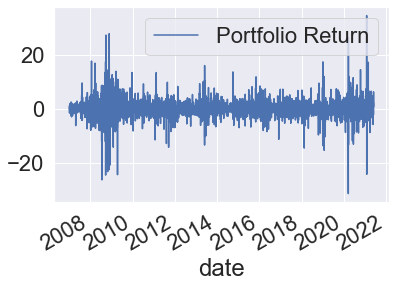

In [519]:
portfolio.plot()

In [520]:
portfolio.dropna(inplace = True)

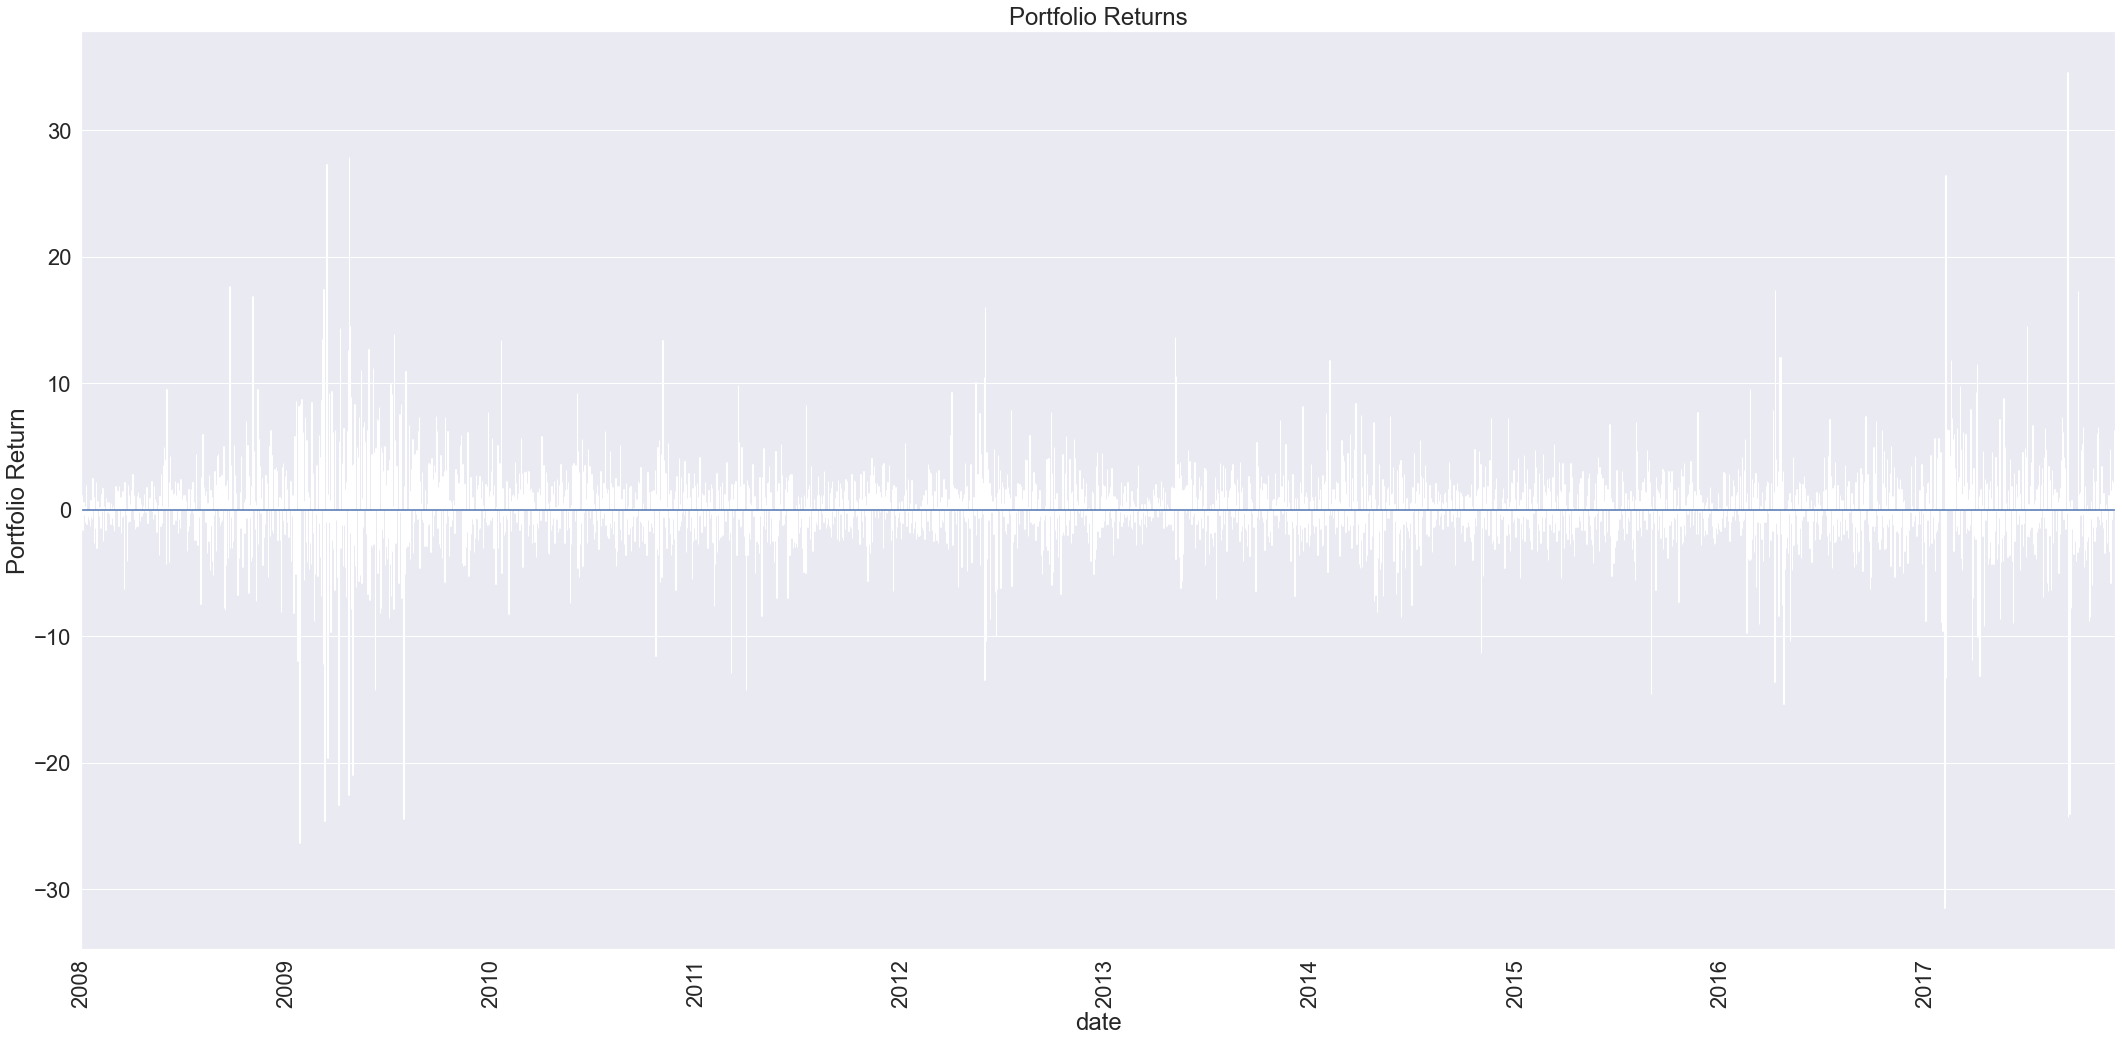

In [521]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(figsize=(30,15))
sns.barplot(x = portfolio.index, y = 'Portfolio Return', data = portfolio, color = 'grey')

axes.xaxis.set_major_locator(mdates.YearLocator())
axes.xaxis.set_minor_locator(mdates.MonthLocator())

ticklabels = [item.strftime('%Y') for item in portfolio.resample('Y').mean().index.to_period('Y')]

axes.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

plt.xticks(rotation = 'vertical')
axes.set_title('Portfolio Returns')

sns.set(font_scale=2)
plt.axhline(0)

plt.tight_layout()


plt.show()

In [522]:
portfolio_monthly = portfolio.resample('M').mean()
portfolio_monthly

Portfolio Return
date                        
2007-01-31         -0.275276
2007-02-28         -0.064677
2007-03-31         -0.260868
2007-04-30          0.317659
2007-05-31          0.136799
...                      ...
2021-01-31          0.491378
2021-02-28         -1.863246
2021-03-31         -1.015891
2021-04-30          0.582295
2021-05-31         -0.002399

[173 rows x 1 columns]

In [523]:
avg_return = portfolio['Portfolio Return'].mean()
print(f'Average return is {avg_return:.2f} %')

Average return is 0.08 %


In [525]:
portfolio.to_csv('results/LinearRegression_PCA.csv')

In [5]:
rolling_avg = pd.read_csv('results/LinearRegression_PCA.csv', index_col = 'date', parse_dates = True)

In [6]:
rolling_avg = pd.DataFrame(data = rolling_avg['Portfolio Return'].rolling(252).mean())

In [7]:
rolling_avg.dropna(inplace = True)

In [8]:
rolling_avg

Portfolio Return
date                        
2008-01-03          0.179496
2008-01-04          0.178986
2008-01-07          0.198788
2008-01-08          0.174407
2008-01-09          0.181654
...                      ...
2021-05-24         -0.329164
2021-05-25         -0.279070
2021-05-26         -0.247000
2021-05-27         -0.211594
2021-05-28         -0.233110

[3375 rows x 1 columns]

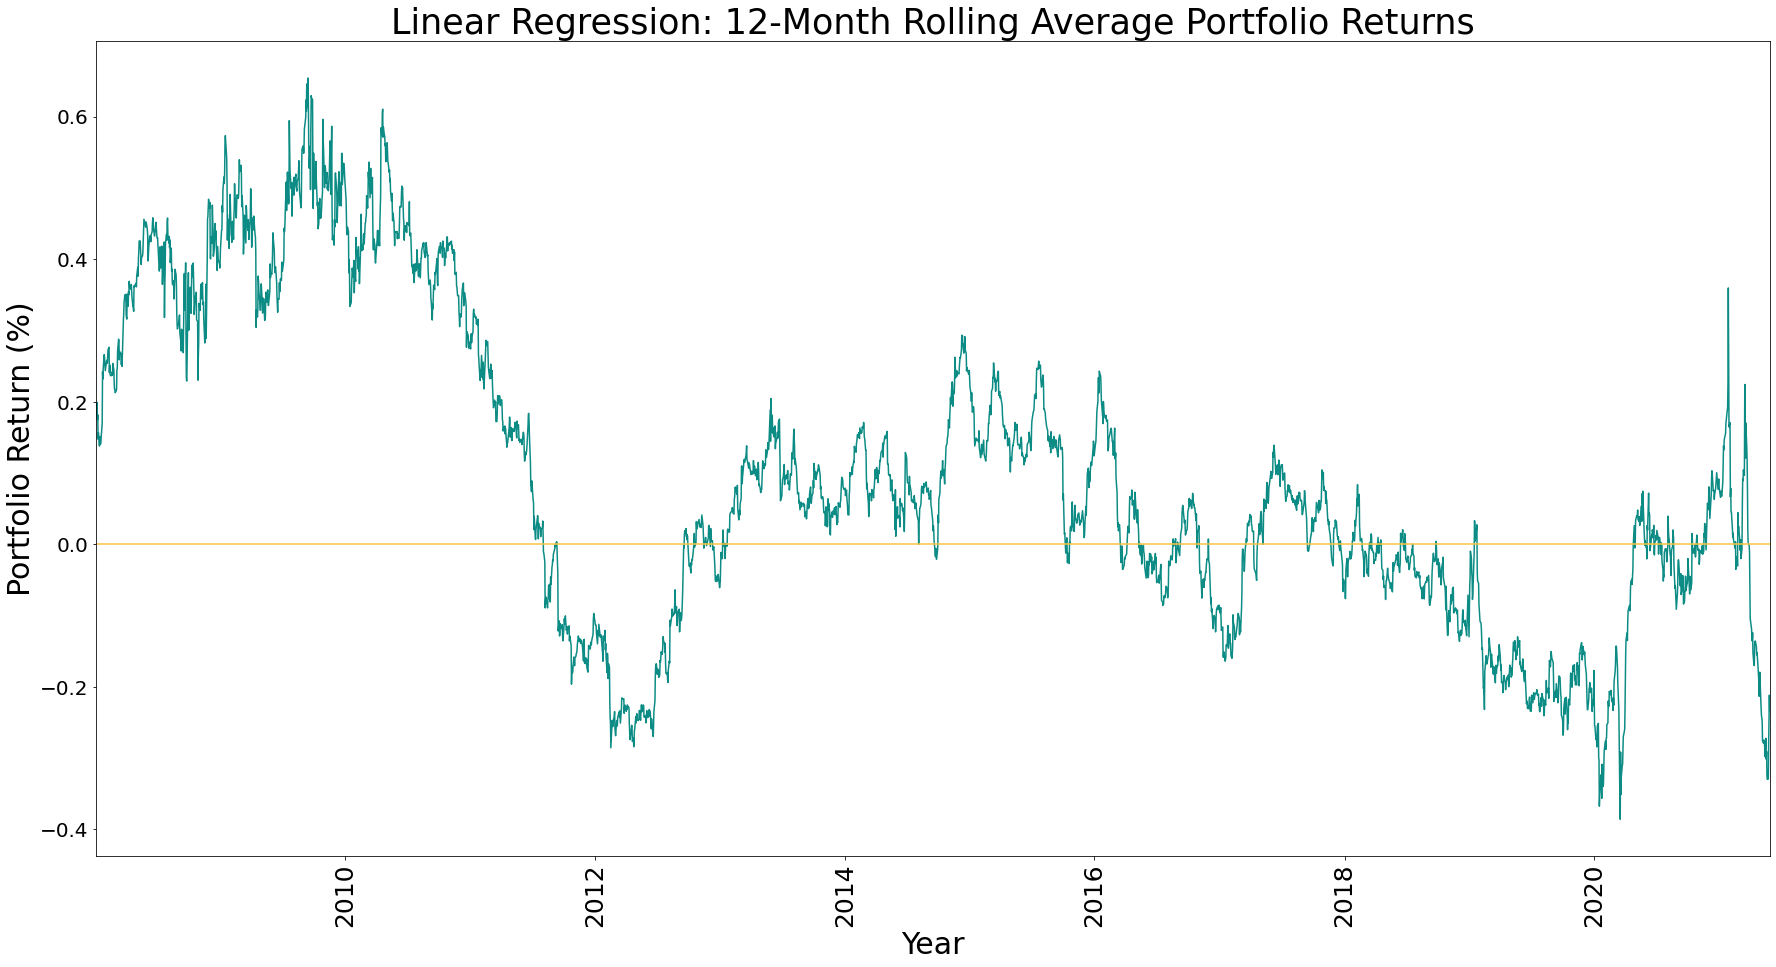

In [10]:
fig, axes = plt.subplots(figsize=(30,15))
sns.lineplot(x=rolling_avg.index, y="Portfolio Return", data=rolling_avg, color = '#0c8c84ff')
plt.xticks(rotation = 'vertical', fontsize = 25)
plt.yticks(fontsize = 20)
axes.set_title('Linear Regression: 12-Month Rolling Average Portfolio Returns', fontsize = 35)
axes.set_xlabel('Year', fontsize = 30)
axes.set_ylabel('Portfolio Return (%)', fontsize = 30)
plt.xlim([rolling_avg.index[0], rolling_avg.index[-1]])
plt.axhline(0, color = '#fcc43cff')